In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tf.version.VERSION

'2.19.0'

In [ ]:
BATCH_SIZE = 32
IMAGE_WIDTH = 255
IMAGE_HEIGHT = 255
CHANNEL = 3
EPOCHS = 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='/content/drive/MyDrive/Potato_Desease',
seed=123,
shuffle = True,
image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
batch_size = BATCH_SIZE
)

Found 957 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[140.99216 135.99216 141.99216]
  [143.9825  138.9825  144.9825 ]
  [143.77287 138.77287 144.77287]
  ...
  [197.62825 192.62825 198.62825]
  [195.98434 190.98434 196.98434]
  [175.06053 170.06053 176.06053]]

 [[134.10179 129.10179 135.10179]
  [135.088   130.088   136.088  ]
  [147.90219 142.90219 148.90219]
  ...
  [188.06946 183.06946 189.06946]
  [182.1473  177.1473  183.1473 ]
  [184.9885  179.9885  185.9885 ]]

 [[150.86485 145.86485 151.86485]
  [137.00652 132.00652 138.00652]
  [143.04997 138.04997 144.04997]
  ...
  [214.58221 209.58221 215.58221]
  [200.9353  195.9353  201.9353 ]
  [184.28732 179.28732 185.28732]]

 ...

 [[156.86661 151.86661 158.86661]
  [158.57663 153.57663 160.57663]
  [125.19407 120.19407 127.19407]
  ...
  [192.6311  189.6311  198.6311 ]
  [177.14233 174.14233 183.14233]
  [175.91406 172.91406 181.91406]]

 [[128.20937 123.20937 130.20937]
  [148.28568 143.28568 150.28568]
  [185.30104

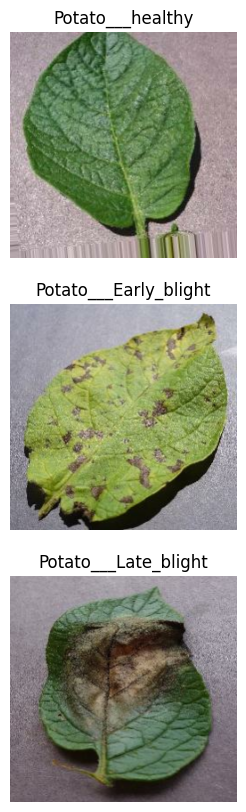

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(3):
        ax = plt.subplot(3, 1, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
len(dataset)

30

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

24

In [ ]:
len(test_ds)

3

In [ ]:
len(val_ds)

3

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)
n_classes = len(class_names)

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 226s 784ms/step - accuracy: 0.3291 - loss: 1.0989 - val_accuracy: 0.4271 - val_loss: 1.0898
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.4334 - loss: 1.0380 - val_accuracy: 0.7188 - val_loss: 0.6277
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.6701 - loss: 0.7007 - val_accuracy: 0.8229 - val_loss: 0.4921
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.8009 - loss: 0.4666 - val_accuracy: 0.8229 - val_loss: 0.3562
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8435 - loss: 0.3923 - val_accuracy: 0.8750 - val_loss: 0.2777
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.8589 - loss: 0.3488 - val_accuracy: 0.8542 - val_loss: 0.2897
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.8239 - loss: 0.3814 - val_accuracy: 0.8542 - val_loss: 0.2937
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8867 - loss: 0.2924 - val_accuracy: 

In [ ]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9522 - loss: 0.1343


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

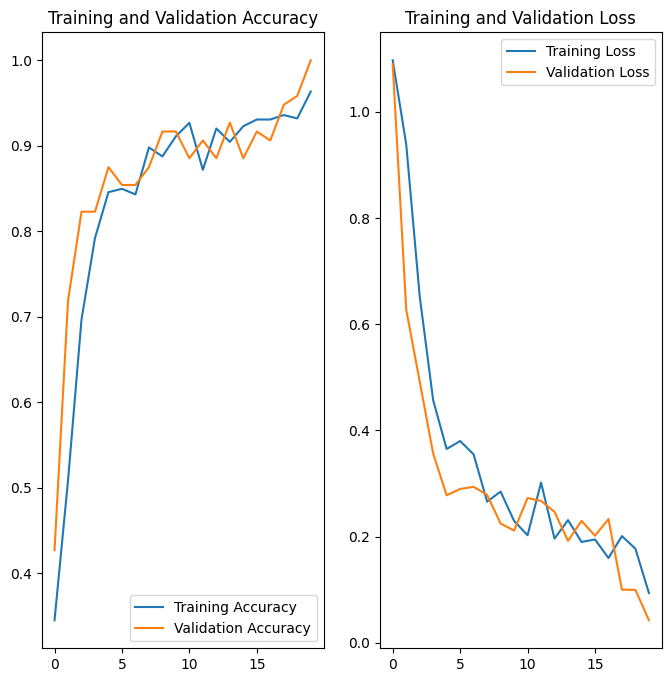

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("potato_disease_cnn.keras")

In [ ]:
def predict_disease(img):
  img_arr = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_arr = tf.expand_dims(img_arr, 0)

  predictions = model.predict(img_arr)

  return class_names[np.argmax(predictions[0])]

In [ ]:
for image, label in test_ds.take(1):
  for i in range(1):
    print(predict_disease(image[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Potato___Late_blight
